In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date']) 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [3]:
len(df)

30155

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

# Set Zipcode

In [5]:
df['address'][4]

'2193 Northwest Talus Drive, Issaquah, Washington 98027, United States'

In [6]:
zipcode = []

for zips in df['address']:
    zipcode.append(int(zips[-20:-15]))
    
df['zipcode'] = zipcode
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


# Fill NaNs and Drop Duplicates

### Duplicates

In [7]:
# Check number of duplicate id's
df['id'].duplicated().sum()

1

In [8]:
# Drop duplicates
df = df.sort_values('id', ascending = False).drop_duplicates(subset = 'id', keep = 'first')

In [9]:
# Ensure that there are no longer duplicates
df.duplicated().sum()

0

### Heat Source

In [10]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      32
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
dtype: int64

In [11]:
# Check out sewer_system
print(df['sewer_system'].value_counts())

PUBLIC                25776
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64


In [12]:
df['heat_source'].fillna('Gas', inplace=True)

In [13]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source       0
sewer_system     14
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
dtype: int64

### Sewer System

In [14]:
heat_count = print(df['sewer_system'].value_counts())

PUBLIC                25776
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64


In [15]:
df['sewer_system'].fillna('PUBLIC', inplace=True)

In [16]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
zipcode          0
dtype: int64

In [17]:
df.drop(['id', 'date'], axis=1, inplace=True)

# Train-Test Split

In [18]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [19]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [20]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [21]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Price

In [22]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(df['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -330000.0 
price_max: 2278000.0


In [23]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [24]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -3378.0 
sqft_lot_max: 18246.0


In [25]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

# Categorical Variables

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25027 entries, 26110 to 10844
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          25027 non-null  float64
 1   bedrooms       25027 non-null  int64  
 2   bathrooms      25027 non-null  float64
 3   sqft_living    25027 non-null  int64  
 4   sqft_lot       25027 non-null  int64  
 5   floors         25027 non-null  float64
 6   waterfront     25027 non-null  object 
 7   greenbelt      25027 non-null  object 
 8   nuisance       25027 non-null  object 
 9   view           25027 non-null  object 
 10  condition      25027 non-null  object 
 11  grade          25027 non-null  object 
 12  heat_source    25027 non-null  object 
 13  sewer_system   25027 non-null  object 
 14  sqft_above     25027 non-null  int64  
 15  sqft_basement  25027 non-null  int64  
 16  sqft_garage    25027 non-null  int64  
 17  sqft_patio     25027 non-null  int64  
 18  yr

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25027 entries, 26110 to 10844
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          25027 non-null  float64
 1   bedrooms       25027 non-null  int64  
 2   bathrooms      25027 non-null  float64
 3   sqft_living    25027 non-null  int64  
 4   sqft_lot       25027 non-null  int64  
 5   floors         25027 non-null  float64
 6   waterfront     25027 non-null  object 
 7   greenbelt      25027 non-null  object 
 8   nuisance       25027 non-null  object 
 9   view           25027 non-null  object 
 10  condition      25027 non-null  object 
 11  grade          25027 non-null  object 
 12  heat_source    25027 non-null  object 
 13  sewer_system   25027 non-null  object 
 14  sqft_above     25027 non-null  int64  
 15  sqft_basement  25027 non-null  int64  
 16  sqft_garage    25027 non-null  int64  
 17  sqft_patio     25027 non-null  int64  
 18  yr

### Bedrooms

In [28]:
bed_count = df['bedrooms'].value_counts()
bed_count

3     11060
4      7613
2      3604
5      2001
6       335
1       281
7        56
0        32
8        29
9        13
10        2
11        1
Name: bedrooms, dtype: int64

In [29]:
#df = df[df['bedrooms'] != 7]
#df = df[df['bedrooms'] != 8]
#df = df[df['bedrooms'] != 9]
#df = df[df['bedrooms'] != 10]
#df = df[df['bedrooms'] != 11]

### Condition

In [30]:
condition_count = df['condition'].value_counts()
condition_count

Average      15585
Good          6572
Very Good     2671
Fair           156
Poor            43
Name: condition, dtype: int64

In [31]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [32]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [33]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Floors

In [34]:
floor_count = print(df['floors'].value_counts())

1.0    11895
2.0     9771
1.5     2055
3.0     1134
2.5      127
4.0       30
3.5       15
Name: floors, dtype: int64


In [35]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [36]:
#X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [37]:
#X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### Grade

In [38]:
grade_count = print(df['grade'].value_counts())

7 Average        10684
8 Good            8204
9 Better          2696
6 Low Average     2553
10 Very Good       499
5 Fair             293
11 Excellent        56
4 Low               31
3 Poor               8
12 Luxury            3
Name: grade, dtype: int64


In [39]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

In [40]:
#df = df[df['grade'] != '3 Poor']
#df = df[df['grade'] != '2 Substandard']
#df = df[df['grade'] != '13 Mansion']
#df = df[df['grade'] != '12 Luxury']

### Nuisance

In [41]:
nuisance_count = print(df['nuisance'].value_counts())

NO     20779
YES     4248
Name: nuisance, dtype: int64


In [42]:
X_train, X_test, encoded_nuisance = ohe(X_train, X_test, ['nuisance'])

In [43]:
X_train['nuisance'] = X_train['nuisance'].map({'NO': 0, 'YES': 1})

In [44]:
X_test['nuisance'] = X_test['nuisance'].map({'NO': 0, 'YES': 1})

### View

In [45]:
view_count = df['view'].value_counts()
view_count

NONE         22808
AVERAGE       1364
GOOD           501
EXCELLENT      192
FAIR           162
Name: view, dtype: int64

In [46]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [47]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [48]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [49]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [50]:
waterfront_count = print(df['waterfront'].value_counts())

NO     24886
YES      141
Name: waterfront, dtype: int64


In [51]:
X_train, X_test, encoded_waterfront = ohe(X_train, X_test, ['waterfront'])

In [52]:
X_train['waterfront'] = X_train['waterfront'].map({'NO': 0, 'YES': 1})

In [53]:
X_test['waterfront'] = X_test['waterfront'].map({'NO': 0, 'YES': 1})

### Zipcode

In [54]:
zipcode_count = print(df['zipcode'].sort_values().value_counts())

98042    789
98103    740
98117    734
98115    719
98038    697
        ... 
85040      1
85207      1
85210      1
85295      1
99705      1
Name: zipcode, Length: 381, dtype: int64


In [55]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Mutlitcollinearity

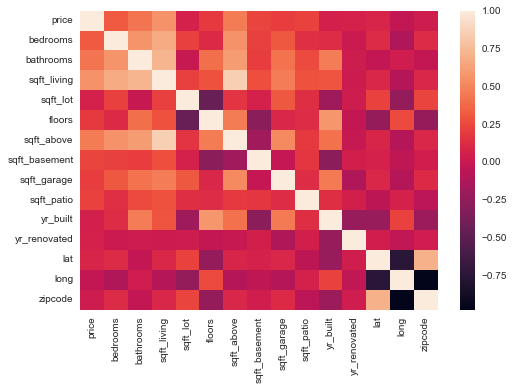

In [56]:
sns.heatmap(df.corr());

In [57]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,zipcode
price,1.000000,0.319345,0.425413,0.557284,0.058544,0.182945,0.455312,0.231022,0.198456,0.227199,0.051270,0.064573,0.082277,-0.028288,0.025380
bedrooms,0.319345,1.000000,0.560719,0.671188,0.209901,0.106436,0.553542,0.212148,0.307552,0.138330,0.122013,0.008187,0.111763,-0.115335,0.112877
bathrooms,0.425413,0.560719,1.000000,0.721762,-0.011429,0.401463,0.598813,0.200101,0.416721,0.256083,0.460196,0.024421,-0.029819,0.034185,-0.028815
sqft_living,0.557284,0.671188,0.721762,1.000000,0.204796,0.284234,0.850249,0.272561,0.461276,0.283702,0.290872,0.019010,0.102845,-0.097107,0.096055
sqft_lot,0.058544,0.209901,-0.011429,0.204796,1.000000,-0.447190,0.165028,0.064947,0.305747,0.132372,-0.199021,0.022022,0.221994,-0.238787,0.230718
floors,0.182945,0.106436,0.401463,0.284234,-0.447190,1.000000,0.452415,-0.294250,0.091384,0.125596,0.571859,-0.031698,-0.242464,0.253072,-0.238115
sqft_above,0.455312,0.553542,0.598813,0.850249,0.165028,0.452415,1.000000,-0.186333,0.516661,0.186799,0.405791,-0.007908,0.087617,-0.089152,0.091604
sqft_basement,0.231022,0.212148,0.200101,0.272561,0.064947,-0.294250,-0.186333,1.000000,-0.025290,0.168377,-0.285549,0.043702,0.063181,-0.046953,0.039229
sqft_garage,0.198456,0.307552,0.416721,0.461276,0.305747,0.091384,0.516661,-0.025290,1.000000,0.123306,0.450165,-0.114143,0.093052,-0.104572,0.105541
sqft_patio,0.227199,0.138330,0.256083,0.283702,0.132372,0.125596,0.186799,0.168377,0.123306,1.000000,0.130110,0.045366,-0.055513,0.058897,-0.059319


In [58]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.557284
sqft_above       0.455312
bathrooms        0.425413
bedrooms         0.319345
sqft_basement    0.231022
sqft_patio       0.227199
sqft_garage      0.198456
floors           0.182945
lat              0.082277
yr_renovated     0.064573
sqft_lot         0.058544
yr_built         0.051270
long             0.028288
zipcode          0.025380
Name: price, dtype: float64

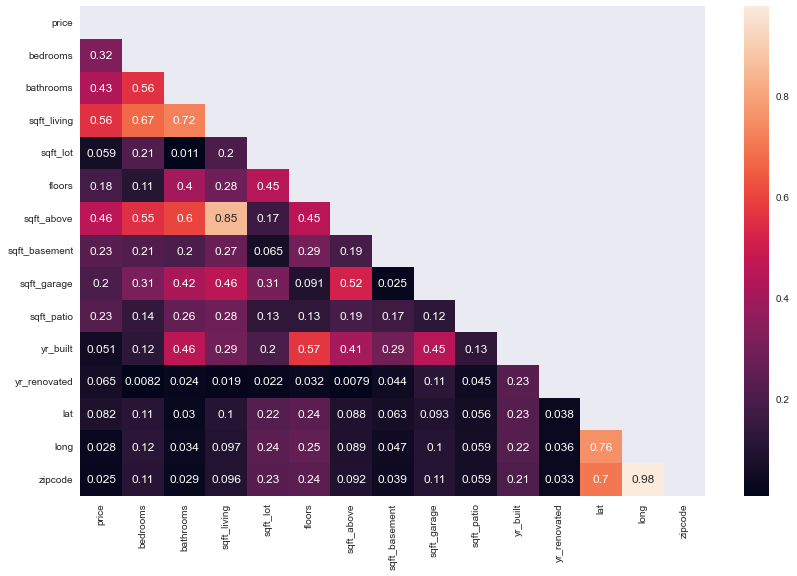

In [59]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_22',bbox_inches="tight");

In [60]:
#df.drop(['sqft_above'], axis=1, inplace=True)

# Models

In [61]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -1.0777585264243328e-06


### Model 1

In [62]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [63]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3691129698911009
    test score: 0.3736435021360339


In [64]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.369
Mean Absolute Error: 396450.899
Mean Squared Error: 505092262603.181
Root Mean Squared Error: 710698.433

Testing Metrics:
R2: 0.374
Mean Absolute Error: 396331.088
Mean Squared Error: 508546968888.510
Root Mean Squared Error: 713124.792


### Model 2

In [65]:
cols = encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [66]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3883254446533785
    test score: 0.35395017258311456


In [67]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.388
Mean Absolute Error: 360124.872
Mean Squared Error: 489710630258.939
Root Mean Squared Error: 699793.277

Testing Metrics:
R2: 0.354
Mean Absolute Error: 370104.965
Mean Squared Error: 524536238714.262
Root Mean Squared Error: 724248.741


### Model 3

In [68]:
cols = encoded_grade

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [69]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.40994533984545645
    test score: 0.40633859834151675


In [70]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.410
Mean Absolute Error: 387734.085
Mean Squared Error: 472401601449.256
Root Mean Squared Error: 687314.776

Testing Metrics:
R2: 0.406
Mean Absolute Error: 383132.718
Mean Squared Error: 482001395992.693
Root Mean Squared Error: 694263.204


### Model 4

In [71]:
cols = encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [72]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.11253601058078844
    test score: 0.13084725600605351


In [73]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.113
Mean Absolute Error: 502001.561
Mean Squared Error: 710509446227.197
Root Mean Squared Error: 842917.224

Testing Metrics:
R2: 0.131
Mean Absolute Error: 492647.915
Mean Squared Error: 705676391905.570
Root Mean Squared Error: 840045.470


### Model 5

In [74]:
cols = encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [75]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.050894181214294454
    test score: 0.06259927381174424


In [76]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.051
Mean Absolute Error: 526886.842
Mean Squared Error: 759860296030.445
Root Mean Squared Error: 871699.659

Testing Metrics:
R2: 0.063
Mean Absolute Error: 517532.650
Mean Squared Error: 761087814308.042
Root Mean Squared Error: 872403.470


### Model 6

In [77]:
cols = encoded_grade + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [78]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.58968027440473
    test score: 0.5696729811939745


In [79]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.590
Mean Absolute Error: 283444.933
Mean Squared Error: 328504642987.917
Root Mean Squared Error: 573153.246

Testing Metrics:
R2: 0.570
Mean Absolute Error: 288427.745
Mean Squared Error: 349388090952.897
Root Mean Squared Error: 591090.595


### Model 7

In [80]:
cols = encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [81]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6260577022688594
    test score: 0.6098325191409901


In [82]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.626
Mean Absolute Error: 275894.538
Mean Squared Error: 299380637467.617
Root Mean Squared Error: 547156.867

Testing Metrics:
R2: 0.610
Mean Absolute Error: 281490.561
Mean Squared Error: 316782040940.539
Root Mean Squared Error: 562833.937


### Model 8

In [83]:
cols = ['sqft_living'] + encoded_grade + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [84]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6340692139650601
    test score: 0.6262915138458002


In [85]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.634
Mean Absolute Error: 253236.713
Mean Squared Error: 292966569058.559
Root Mean Squared Error: 541263.863

Testing Metrics:
R2: 0.626
Mean Absolute Error: 256478.358
Mean Squared Error: 303418769550.160
Root Mean Squared Error: 550834.612


### Model 9

In [86]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [87]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6636790843219613
    test score: 0.6574085907343786


In [88]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.664
Mean Absolute Error: 247264.664
Mean Squared Error: 269260714127.015
Root Mean Squared Error: 518903.376

Testing Metrics:
R2: 0.657
Mean Absolute Error: 250829.965
Mean Squared Error: 278154411015.807
Root Mean Squared Error: 527403.461


### Model 10

In [89]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_waterfront + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [90]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6708804526325762
    test score: 0.667819806639412


In [91]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.671
Mean Absolute Error: 248299.567
Mean Squared Error: 263495251785.494
Root Mean Squared Error: 513317.886

Testing Metrics:
R2: 0.668
Mean Absolute Error: 250564.100
Mean Squared Error: 269701409715.422
Root Mean Squared Error: 519327.844


In [92]:
kcols = sm.OLS(y_train, sm.add_constant(X_train[['sqft_living', 'view', 'waterfront']])).fit()
kcols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     5267.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:12:55   Log-Likelihood:            -3.3602e+05
No. Observations:               22615   AIC:                         6.720e+05
Df Residuals:                   22611   BIC:                         6.721e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.741e+05   1.21e+04    -14.356      0.000   -1.98e+05    -1.5e+05
sqft_living   523.8455      4.839    108.245      0.000     514.360     533.331
view         1.251e+05   6063.804     20.626      0.000    1.13e+05    1.37e+05
waterfront     8.6e+05   3.86e+04     22.294      0.000    7.84e+05    9.36e+05
==============================================================================
Omnibus:                    32223.693   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         40261216.741
Skew:                           7.938   Prob(JB):                         0.00
Kurtosis:                     209.094   Cond. No.                     1.97e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 11

In [93]:
cols = ['bathrooms', 'bedrooms', 'floors', 'sqft_living', 'yr_built'] + encoded_zipcode + encoded_grade + encoded_view + encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [94]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6719777553436752
    test score: 0.6687600094585257


In [95]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.672
Mean Absolute Error: 247050.270
Mean Squared Error: 262616744092.898
Root Mean Squared Error: 512461.456

Testing Metrics:
R2: 0.669
Mean Absolute Error: 249646.298
Mean Squared Error: 268938046845.505
Root Mean Squared Error: 518592.371
